In [26]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import scipy.stats as st

from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn import tree
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score
from sklearn.preprocessing import MinMaxScaler
import pickle

***Clasificacion***

*Creacion de target*

Para esta tarea se debe crear una nueva variable tipo_precio que tendrá tres categorías:
alto, medio, bajo.

In [27]:
ds_clasificacion = pd.read_csv("properati_argentina_reducido_train.csv")
test = pd.read_csv("properati_argentina_reducido_test.csv")
ds_clasificacion.drop(columns = ["Unnamed: 0"], inplace=True)
test.drop(columns = ["Unnamed: 0"], inplace=True)

In [28]:
ds_clasificacion["precioxm2"] = (ds_clasificacion["property_price"]/ds_clasificacion["property_surface_total"]).round(2)
test["precioxm2"] = (test["property_price"]/test["property_surface_total"]).round(2)
ds_clasificacion.head(10)

,latitud,longitud,property_type,property_rooms,property_surface_total,property_price,precioxm2
0,-34.559318,-58.445475,Departamento,3.0,66.0,179000.0,2712.12
1,-34.610368,-58.441225,Departamento,3.0,67.0,160000.0,2388.06
2,-34.616446,-58.379481,Departamento,1.0,40.0,67900.0,1697.50
3,-34.619406,-58.451999,Departamento,1.0,38.0,80000.0,2105.26
4,-34.605707,-58.415998,Departamento,2.0,37.0,68000.0,1837.84
5,-34.592911,-58.404489,Departamento,3.0,83.0,280000.0,3373.49
6,-34.592457,-58.412753,Departamento,1.0,43.0,141000.0,3279.07
7,-34.614614,-58.407063,Departamento,3.0,58.0,135000.0,2327.59
8,-34.596903,-58.410538,Departamento,3.0,62.0,169900.0,2740.32
9,-34.672922,-58.481074,Departamento,3.0,55.0,60000.0,1090.91


In [29]:
test.head()

,latitud,longitud,property_type,property_rooms,property_surface_total,property_price,precioxm2
0,-34.575825,-58.434324,Departamento,3.0,84.0,140000.0,1666.67
1,-34.569851,-58.478504,Departamento,3.0,75.0,170000.0,2266.67
2,-34.592793,-58.384974,Departamento,4.0,220.0,750000.0,3409.09
3,-34.630323,-58.486175,Departamento,3.0,74.0,130000.0,1756.76
4,-34.585164,-58.421009,Departamento,1.0,20.0,55000.0,2750.00


Igual Frecuencia

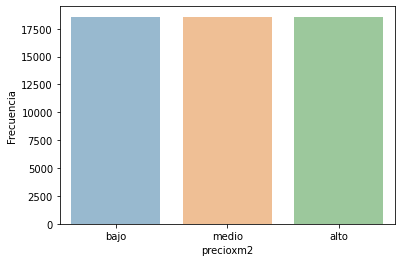

In [30]:
labels=["bajo","medio","alto"]

ds_clasificacion["precioxm2_igual_frec"]=pd.qcut(ds_clasificacion["precioxm2"],q=3, labels=labels)

#Gráfico de barras con Seaborn
ds_agrupado_precioxm2=ds_clasificacion.groupby(['precioxm2_igual_frec']).count()  #Calculo la frecuencia de cada categoría

eje_x = ds_agrupado_precioxm2.index.tolist()   ## Declaramos valores para el eje x
eje_y = ds_agrupado_precioxm2['precioxm2'].tolist()  ## Declaramos valores para el eje y

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, data=ds_agrupado_precioxm2 ,alpha=0.5).set(title="",ylabel='Frecuencia',xlabel='precioxm2')
plt.show()

Por cuantiles

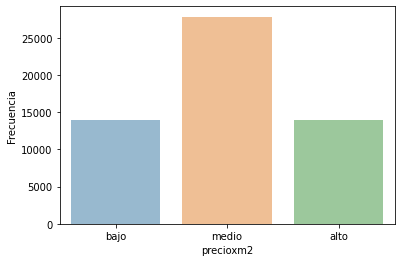

In [31]:
labels=["bajo","medio","alto"]
ds_clasificacion["precioxm2_q"]=pd.qcut(ds_clasificacion["precioxm2"],q=[0,0.25,0.75,1], labels=labels)

#Gráfico de barras con Seaborn
ds_agrupado_precioxm2=ds_clasificacion.groupby(['precioxm2_q']).count()  #Calculo la frecuencia de cada categoría

eje_x = ds_agrupado_precioxm2.index.tolist()   ## Declaramos valores para el eje x
eje_y = ds_agrupado_precioxm2['precioxm2'].tolist()  ## Declaramos valores para el eje y

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, data=ds_agrupado_precioxm2 ,alpha=0.5).set(title="",ylabel='Frecuencia',xlabel='precioxm2')
plt.show()

In [32]:
quantil_menor=ds_clasificacion["precioxm2"].quantile(q=0.25)
quantil_mayor=ds_clasificacion["precioxm2"].quantile(q=0.75)
test["precioxm2_q"]= pd.NA
test.loc[test["precioxm2"]<quantil_menor,"precioxm2_q"] = "bajo"
test.loc[test["precioxm2"]>quantil_mayor,"precioxm2_q"] = "alto"
test.loc[(test["precioxm2"]<=quantil_mayor) & (test["precioxm2"]>=quantil_menor),"precioxm2_q"] = "medio" 

Por viviendas

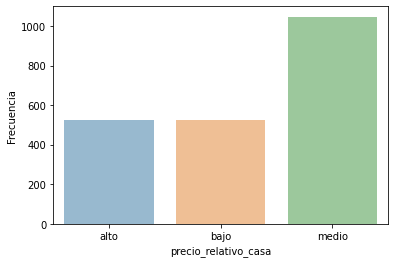

In [33]:
ds_clasificacion["precioxm2_relativo_q"] = np.nan
labels=["bajo","medio","alto"]
ds_clasificacion.loc[ds_clasificacion["property_type"] == "Casa", "precioxm2_relativo_q"]=pd.qcut(ds_clasificacion[ds_clasificacion["property_type"] == "Casa"]["precioxm2"],q=[0,0.25,0.75,1], labels=labels)
ds_clasificacion.loc[ds_clasificacion["property_type"] == "Departamento", "precioxm2_relativo_q"]=pd.qcut(ds_clasificacion[ds_clasificacion["property_type"] == "Departamento"]["precioxm2"],q=[0,0.25,0.75,1], labels=labels)
ds_clasificacion.loc[ds_clasificacion["property_type"] == "PH", "precioxm2_relativo_q"]=pd.qcut(ds_clasificacion[ds_clasificacion["property_type"] == "PH"]["precioxm2"],q=[0,0.25,0.75,1], labels=labels)

#Gráfico de barras con Seaborn
ds_agrupado_precioxm2=ds_clasificacion[ds_clasificacion["property_type"] == "Casa"].groupby(['precioxm2_relativo_q']).count()  #Calculo la frecuencia de cada categoría

eje_x = ds_agrupado_precioxm2.index.tolist()   ## Declaramos valores para el eje x
eje_y = ds_agrupado_precioxm2['precioxm2'].tolist()  ## Declaramos valores para el eje y

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, data=ds_agrupado_precioxm2 ,alpha=0.5).set(title="",ylabel='Frecuencia',xlabel='precio_relativo_casa')
plt.show()

Observacion de que tipos de viviendas son mas economicas en precio por metro cuadrado

In [34]:
ds_clasificacion[(ds_clasificacion["precioxm2_q"] == "bajo")&(ds_clasificacion["property_type"]=="PH")].shape[0] / ds_clasificacion[(ds_clasificacion["property_type"]=="PH")].shape[0]

0.6399305555555556

In [35]:
ds_clasificacion[(ds_clasificacion["precioxm2_q"] == "bajo")&(ds_clasificacion["property_type"]=="Departamento")].shape[0] / ds_clasificacion[(ds_clasificacion["property_type"]=="Departamento")].shape[0]

0.18382014959675735

In [36]:
ds_clasificacion[(ds_clasificacion["precioxm2_q"] == "bajo")&(ds_clasificacion["property_type"]=="Casa")].shape[0] / ds_clasificacion[(ds_clasificacion["property_type"]=="Casa")].shape[0]

0.6914995224450812

distribuicion de precios

<AxesSubplot:>

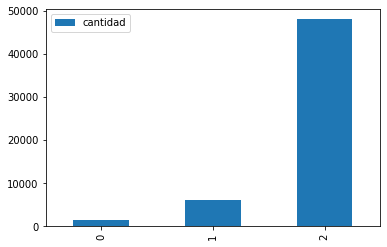

In [37]:
precio_bajo = (ds_clasificacion[ds_clasificacion["precioxm2"]<1000]).shape[0]
precio_medio = (ds_clasificacion[ds_clasificacion["precioxm2"]>=1000]).shape[0] - (ds_clasificacion[ds_clasificacion["precioxm2"]>=1500]).shape[0]
precio_alto = (ds_clasificacion[ds_clasificacion["precioxm2"]>=1500]).shape[0]

df_precios = pd.DataFrame(list(zip(["bajo","medio","alto"], [precio_bajo, precio_medio, precio_alto])), columns=["clasificacion", "cantidad"])
df_precios.plot.bar()

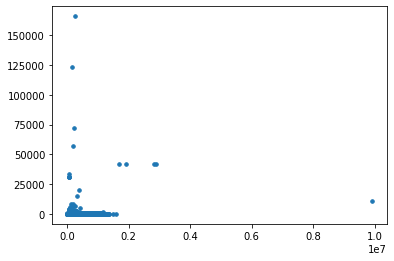

In [38]:
from sklearn.cluster import KMeans

#Generamos un dataset sintético
xy= ds_clasificacion[["property_price","property_surface_total"]]

plt.scatter(xy["property_price"], xy["property_surface_total"], s=50,marker='.')
plt.show()
kmeans = KMeans(n_clusters=3)  #Creamos un objeto de la clase KMeans para realizar el agrupamiento

kmeans.fit(xy) #Entrenamos el algoritmo para que aprenda cómo agrupar

y_kmeans = kmeans.predict(xy)



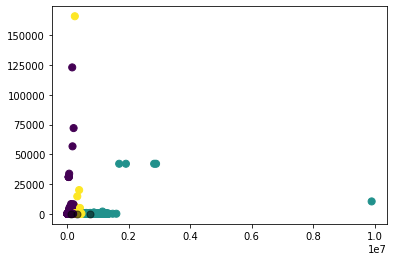

In [39]:
plt.scatter(xy["property_price"], xy["property_surface_total"], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5,marker='.')
plt.show()

Viendo los resultados notamos que la clasificacion por clusters no es correspondiente a las anteriores clasificaciones ya que no es muy precisa al tomar en cuenta la superficie total

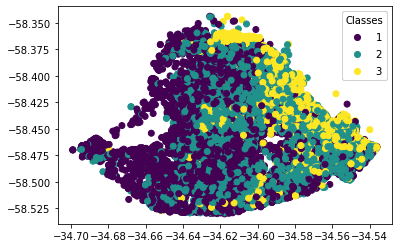

In [40]:
fig, ax = plt.subplots()
x=ds_clasificacion["latitud"]
y=ds_clasificacion["longitud"]
ds_clasificacion.loc[ds_clasificacion['precioxm2_q'] == "bajo",'color'] = 1
ds_clasificacion.loc[ds_clasificacion['precioxm2_q'] == "medio",'color'] = 2
ds_clasificacion.loc[ds_clasificacion['precioxm2_q'] == "alto",'color'] = 3

scatter = ax.scatter(x, y, c=ds_clasificacion['color'])
legend1 = ax.legend(*scatter.legend_elements(),
                     title="Classes")
ax.add_artist(legend1)
plt.show()

Como podemos observar, las viviendas de mayor valor se ubican en la zona este/norte de la ciudad, lo que es bastante coincidente a la realidad.

# **Entrenamiento y Predicción

Predeciccion del valor del atributo tipo_precio,

In [41]:
ds_clasificacion

,latitud,longitud,property_type,property_rooms,property_surface_total,property_price,precioxm2,precioxm2_igual_frec,precioxm2_q,precioxm2_relativo_q,color
0,-34.559318,-58.445475,Departamento,3.0,66.000000,179000.0,2712.12,alto,medio,medio,2.0
1,-34.610368,-58.441225,Departamento,3.0,67.000000,160000.0,2388.06,medio,medio,medio,2.0
2,-34.616446,-58.379481,Departamento,1.0,40.000000,67900.0,1697.50,bajo,bajo,bajo,1.0
3,-34.619406,-58.451999,Departamento,1.0,38.000000,80000.0,2105.26,medio,medio,medio,2.0
4,-34.605707,-58.415998,Departamento,2.0,37.000000,68000.0,1837.84,bajo,medio,bajo,2.0
...,...,...,...,...,...,...,...,...,...,...,...
55711,-34.592190,-58.404974,Departamento,3.0,68.000000,195000.0,2867.65,alto,alto,alto,3.0
55712,-34.584945,-58.399825,Departamento,1.0,38.000000,128000.0,3368.42,alto,alto,alto,3.0
55713,-34.611670,-58.430043,Departamento,2.0,47.606547,62000.0,1302.34,bajo,bajo,bajo,1.0
55714,-34.607711,-58.390811,Departamento,2.0,34.000000,69000.0,2029.41,medio,medio,medio,2.0


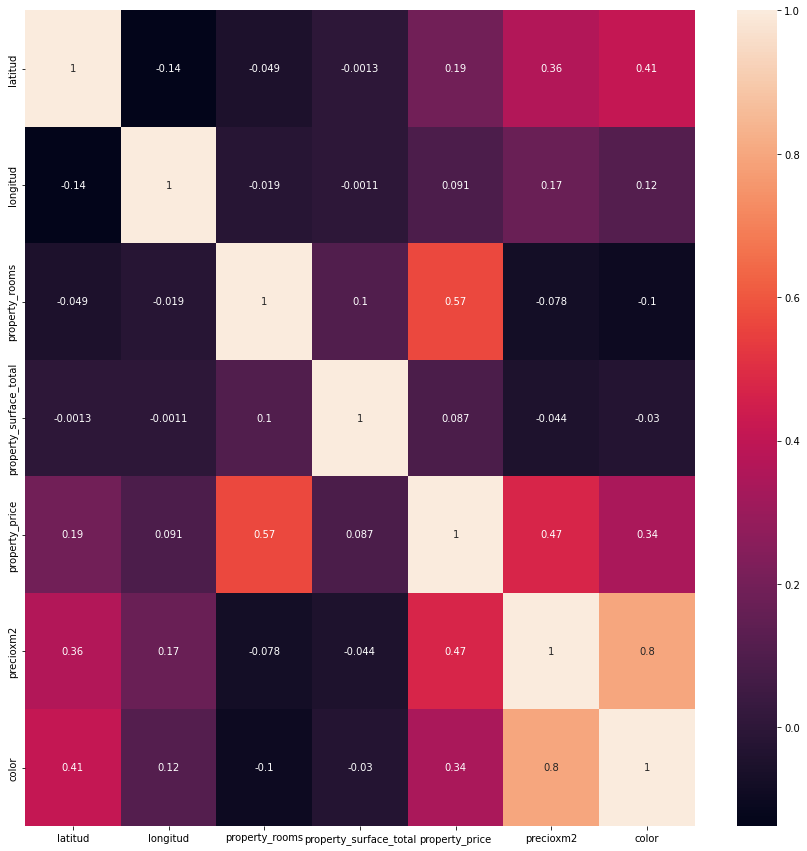

In [42]:
matriz_correlacion=ds_clasificacion.corr()

plt.figure(figsize=(15,15))
sns.heatmap(matriz_correlacion, annot = True)
plt.show()

In [43]:
features=['property_rooms','property_surface_total','latitud','longitud']
          
target='precioxm2_q'

In [44]:
#Verifico balanceo de clases
ds_clasificacion[target].value_counts(normalize=True)*100 #capaz tendriamos que tomar uno que este mas balanceado

medio    49.994616
bajo     25.005384
alto     25.000000
Name: precioxm2_q, dtype: float64

In [45]:
test.head()

,latitud,longitud,property_type,property_rooms,property_surface_total,property_price,precioxm2,precioxm2_q
0,-34.575825,-58.434324,Departamento,3.0,84.0,140000.0,1666.67,bajo
1,-34.569851,-58.478504,Departamento,3.0,75.0,170000.0,2266.67,medio
2,-34.592793,-58.384974,Departamento,4.0,220.0,750000.0,3409.09,alto
3,-34.630323,-58.486175,Departamento,3.0,74.0,130000.0,1756.76,bajo
4,-34.585164,-58.421009,Departamento,1.0,20.0,55000.0,2750.00,alto


In [46]:

x_train = ds_clasificacion[features]
x_test = test[features]
y_train= ds_clasificacion[target]
y_test= test[target]



In [47]:
print(y_test)

0         bajo
1        medio
2         alto
3         bajo
4         alto
         ...  
13924     alto
13925    medio
13926    medio
13927    medio
13928    medio
Name: precioxm2_q, Length: 13929, dtype: object


In [48]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
#from ensurepip import bootstrap
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer,f1_score
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier



#Cantidad de combinaciones que quiero porbar
n=10 

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(1,10)),
               'min_samples_split': list(range(12,20)),
               'ccp_alpha':np.linspace(0.001,0.005,n), 
               'max_depth':list(range(5,6))}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score, average='micro')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 
randomcv.fit(x_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(),
                   param_distributions={'ccp_alpha': array([0.001     , 0.00144444, 0.00188889, 0.00233333, 0.00277778,
       0.00322222, 0.00366667, 0.00411111, 0.00455556, 0.005     ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [12, 13, 14, 15,
                                                              16, 17, 18, 19]},
                   scoring=make_scorer(f1_score, average=micro))

In [49]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'min_samples_split': 14, 'min_samples_leaf': 3, 'max_depth': 5, 'criterion': 'entropy', 'ccp_alpha': 0.001888888888888889}
0.5962920846459964


In [50]:
randomcv.cv_results_['mean_test_score']

array([0.59629208, 0.59307931, 0.59629208, 0.59426391, 0.5792951 ,
       0.57672851, 0.59426391, 0.58889731, 0.57741055, 0.58521787])

In [51]:
#Atributos considerados y su importancia
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,features)):
  print('{}: {}'.format(feat,feat_imp))

property_rooms: 0.0
property_surface_total: 0.1434551579727203
longitud: 0.2553544391571051
latitud: 0.6011904028701747


In [52]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

reglas = export_text(arbol, feature_names=list(features))
print(reglas)

|--- latitud <= -34.60
|   |--- longitud <= -58.37
|   |   |--- property_surface_total <= 85.02
|   |   |   |--- latitud <= -34.63
|   |   |   |   |--- class: bajo
|   |   |   |--- latitud >  -34.63
|   |   |   |   |--- longitud <= -58.42
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- longitud >  -58.42
|   |   |   |   |   |--- class: medio
|   |   |--- property_surface_total >  85.02
|   |   |   |--- property_surface_total <= 201.79
|   |   |   |   |--- latitud <= -34.64
|   |   |   |   |   |--- class: bajo
|   |   |   |   |--- latitud >  -34.64
|   |   |   |   |   |--- class: bajo
|   |   |   |--- property_surface_total >  201.79
|   |   |   |   |--- class: bajo
|   |--- longitud >  -58.37
|   |   |--- latitud <= -34.63
|   |   |   |--- class: bajo
|   |   |--- latitud >  -34.63
|   |   |   |--- class: alto
|--- latitud >  -34.60
|   |--- longitud <= -58.47
|   |   |--- property_surface_total <= 83.21
|   |   |   |--- latitud <= -34.58
|   |   |   |   |--- class: medio
| 

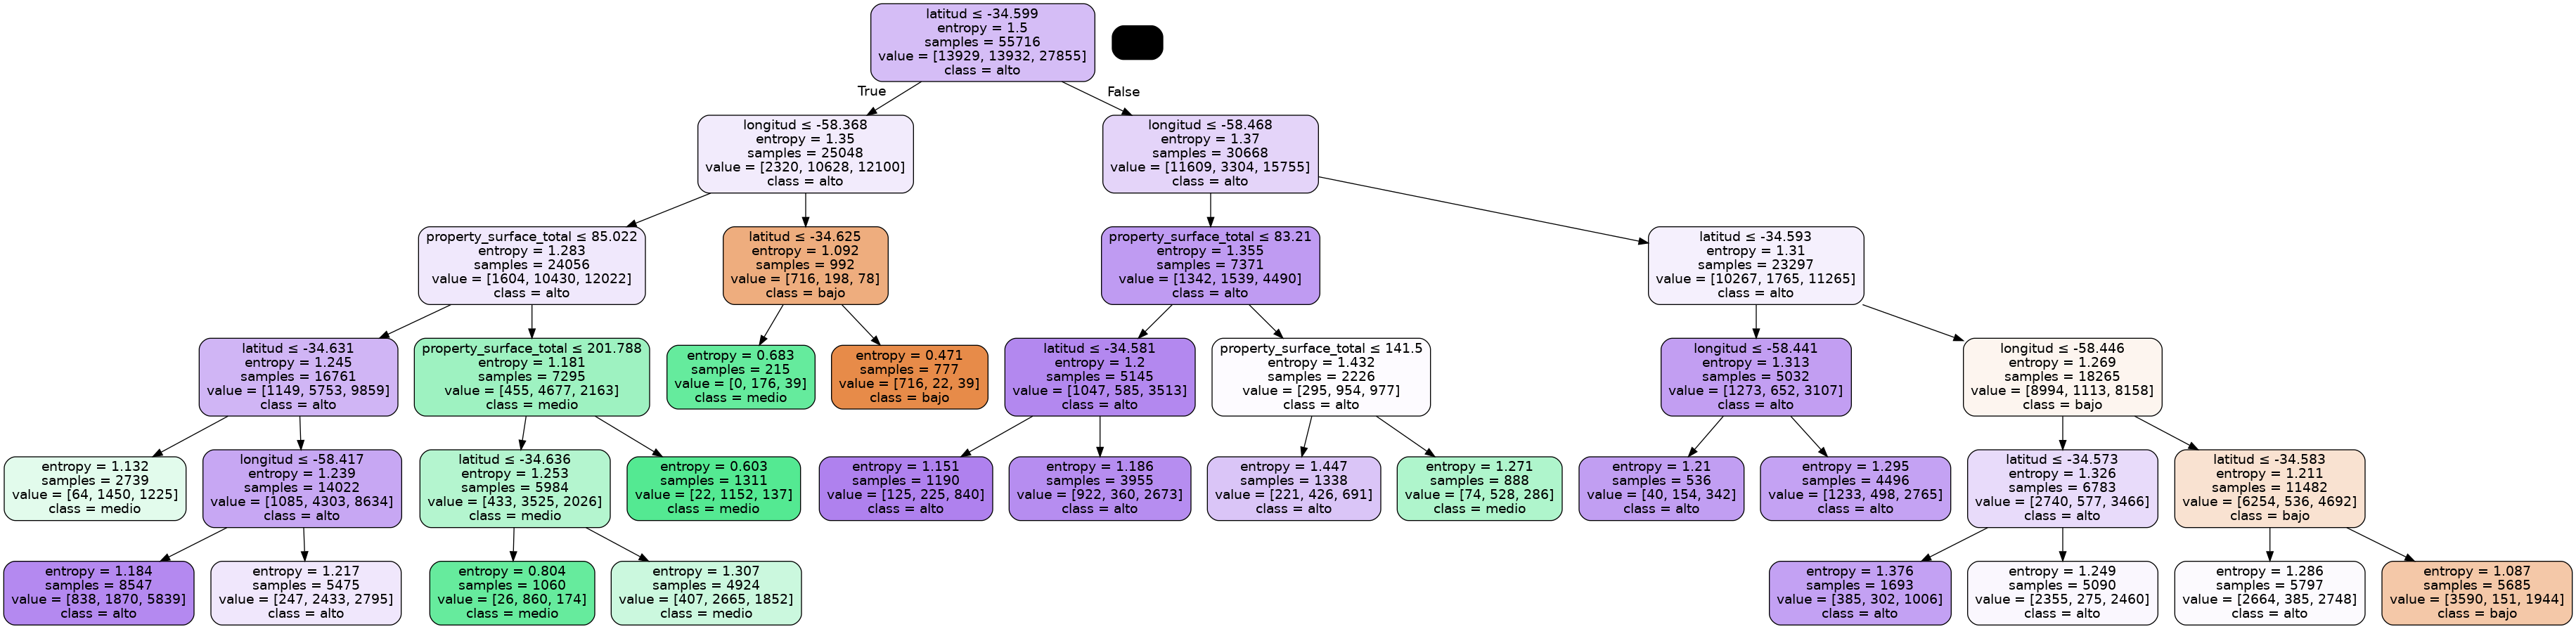

In [53]:
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['bajo','medio','alto'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

***explicacion***

F1-Score: 0.5973867470744489


Text(33.0, 0.5, 'True')

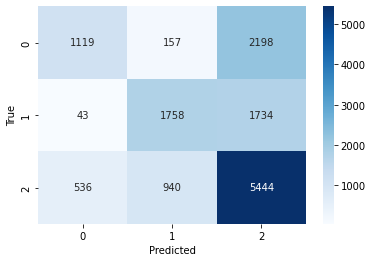

In [54]:
#Evalúo el Arbol con los mejores hiperparámetros
from sklearn.metrics import confusion_matrix, classification_report , f1_score

#Hago predicción sobre el set de evaluacion
y_pred= arbol.predict(x_test)

#Arbol Reporte y Matriz de Confusion
#print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='micro'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')



Persistimos el modelo


In [55]:

#filename = "arbol_decision_model.sav"
#pickle.dump(arbol, open(filename, 'wb'))

# Random Forest


In [56]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, truncnorm, randint
from scipy.stats import randint as sp_randInt


x_train = ds_clasificacion[features]
x_test = test[features]
y_train= ds_clasificacion[target]
y_test= test[target]



#Cantidad de combinaciones que quiero porbar
n=4

#Conjunto de parámetros que quiero usar
#param_grid_rf = {'n_estimators': randint(4,200),'max_depth': [6,7,8], 'min_samples_split': uniform(0.01, 0.199) }


param_grid_rf = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(1,10)),
               'min_samples_split': uniform(0.01, 0.199),
               'ccp_alpha':np.linspace(0,0.15,n), 
               'max_depth':list(range(5,6))}
                






#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree_rf = RandomForestClassifier()#n_estimators=648


#Metrica que quiero optimizar F1 Score
from sklearn.metrics import make_scorer, roc_auc_score, recall_score, matthews_corrcoef, balanced_accuracy_score, accuracy_score
scorer_fn = make_scorer(f1_score, average='micro')

#scoring = {"roc_auc_score": new_auc, "recall": recall, "MCC" : mcc, 'Bal_acc' : bal_acc, "Accuracy": acc }

#scoring = {"roc_auc_score": auc_score, "recall": recall, "MCC" : mcc, 'Bal_acc' : bal_acc, "Accuracy": acc }
#Random Search Cross Validation
randomcv_rf = RandomizedSearchCV(estimator=base_tree_rf,
                              param_distributions = param_grid_rf,
                               cv=kfoldcv,
                            scoring = scorer_fn,
                            n_jobs=-1)
randomcv_rf.fit(x_train,y_train)


randomcv_rf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=9,
                       min_samples_split=0.03213414385662961)

In [57]:
print(randomcv_rf.best_params_)

{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 0.03213414385662961}


In [58]:
arbol_rf=DecisionTreeClassifier().set_params(**randomcv_rf.best_params_)

#Entreno el arbol en todo el set
arbol_rf.fit(x_train,y_train)

reglas_rf = export_text(arbol_rf, feature_names=list(features))

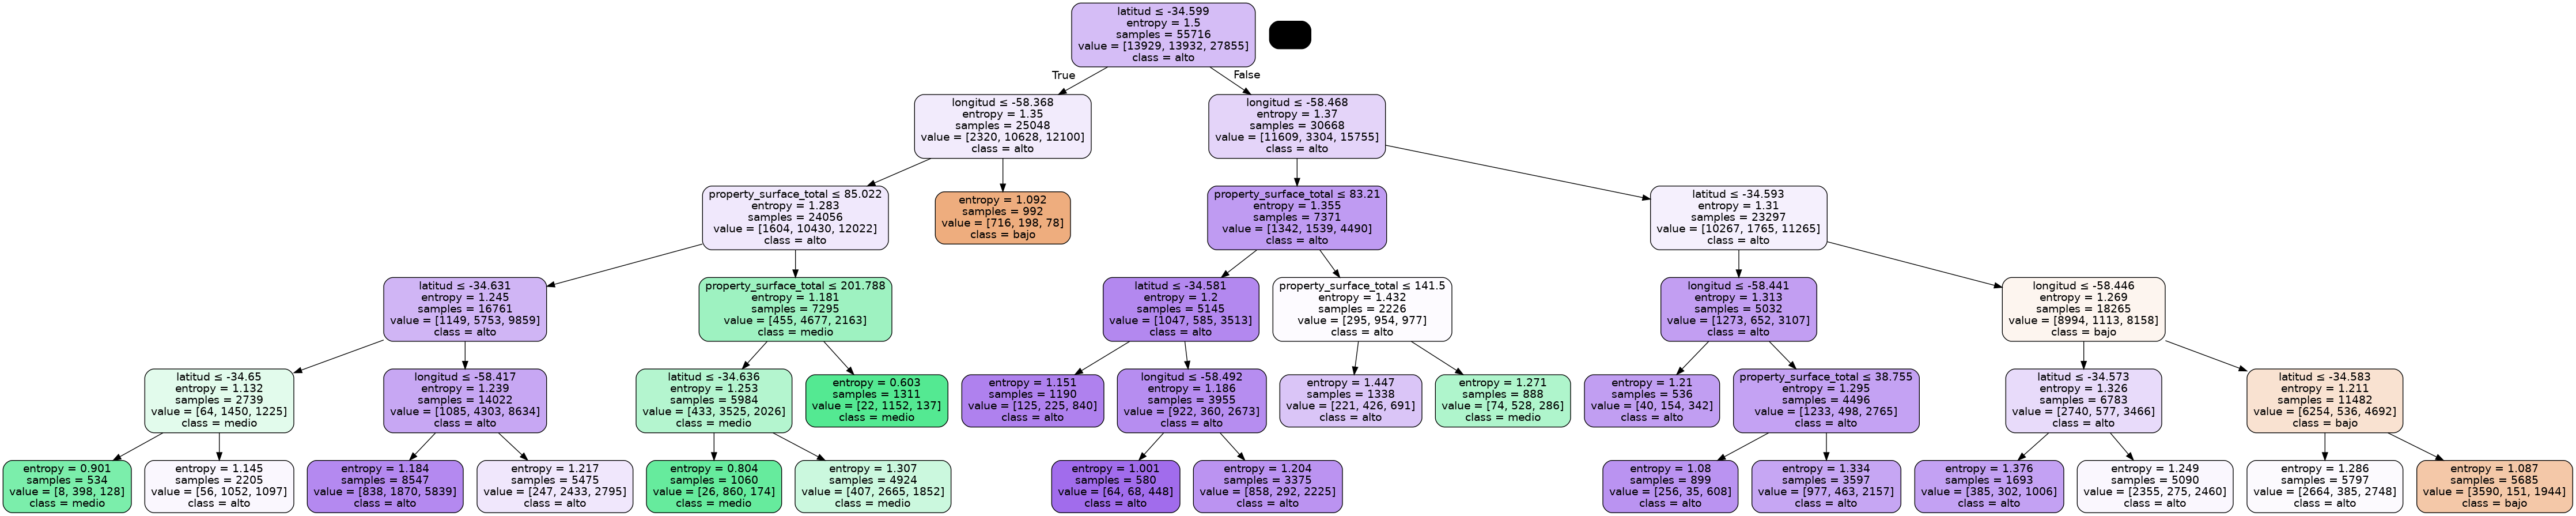

In [59]:
dot_data = StringIO()
export_graphviz(arbol_rf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['bajo','medio','alto'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

F1-Score: 0.5970995764232896


Text(33.0, 0.5, 'True')

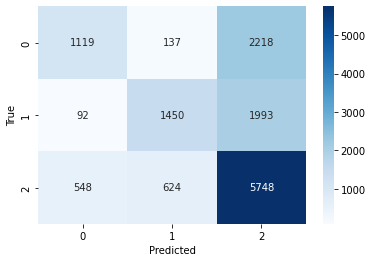

In [60]:
#Hago predicción sobre el set de evaluacion
y_pred= arbol_rf.predict(x_test)

#Arbol Reporte y Matriz de Confusion
#print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='micro'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Persistimos el modelo

In [61]:
#filename = "random_forest_model.sav"
#pickle.dump(arbol_rf, open(filename, 'wb'))

# KNneighborts

In [62]:
from sklearn.neighbors import KNeighborsClassifier

#Clasificador
knn=KNeighborsClassifier(n_neighbors=1)



knn.fit(x_train,y_train)



KNeighborsClassifier(n_neighbors=1)

In [63]:
y_pred_knn= knn.predict(x_test)

In [64]:
result = confusion_matrix(y_test, y_pred_knn)

Text(33.0, 0.5, 'True')

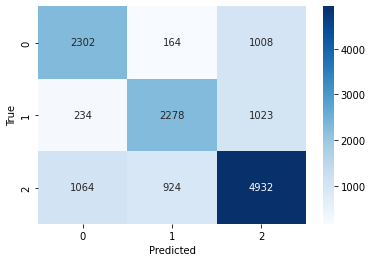

In [65]:
sns.heatmap(result, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [66]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred_knn, average='micro'))) #binary considera la clase positiva por defecto 1


F1-Score: 0.6828918084571757


In [67]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(knn, x_train, y_train, cv=15)

In [68]:
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 35)}
#use gridsearch to test all values for n_neighbors
knn_2=KNeighborsClassifier()
knn_gscv = GridSearchCV(knn_2, param_grid, cv=5)
knn_gscv.fit(x_train, y_train)
knn_gscv.best_params_

{'n_neighbors': 1}

In [69]:
print("cv_scores mean:{}".format(np.mean(cv_scores)))

cv_scores mean:0.6783688264525024


Persistimos el modelo

In [70]:
#filename = "knn_model.sav"
#pickle.dump(knn_gscv, open(filename, 'wb'))